```
This notebook sets up and runs a set of benchmarks to compare
different numerical discretizations of the SWEs

Copyright (C) 2016  SINTEF ICT

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# MPI Skeleton for basic particle filter with SIR




## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import ipyparallel
import sys
import os

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

from SWESimulators import IPythonMagic, Common

# attach to a running cluster
#cluster = ipyparallel.Client()#profile='mpi')

# start cluster
%setup_mpi mpi_context --num_engines 3
cluster = mpi_context.cluster

print('profile:', cluster.profile)
print('Number of ids:', len(cluster.ids))
print("IDs:", cluster.ids) # Print process id numbers

profile: default
Number of ids: 3
IDs: [0, 1, 2]


In [4]:
%%px 

%matplotlib inline

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


import numpy as np
from mpi4py import MPI
import gc, os, sys

#Import our simulator
from SWESimulators import MPIOceanModelEnsemble, IPythonMagic

In [5]:
%%px 

#Tests that MPI actually works

comm = MPI.COMM_WORLD

print("Hello! I'm rank %d from %d running in total..." % (comm.rank, comm.size))

#Make results deterministic
np.random.seed(seed=(42 + comm.rank))
comm.Barrier()   

[stdout:0] Hello! I'm rank 0 from 3 running in total...
[stdout:1] Hello! I'm rank 1 from 3 running in total...
[stdout:2] Hello! I'm rank 2 from 3 running in total...


In [6]:
%%px


%setup_logging -o "'mpi_' + str(MPI.COMM_WORLD.rank) + '.log'"

[stderr:0] 
Console logger using level INFO
File logger using level DEBUG to 'mpi_' + str(MPI.COMM_WORLD.rank) + '.log'
Python version 3.7.2 (default, Mar 13 2019, 14:18:46) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]
[stderr:1] 
Console logger using level INFO
File logger using level DEBUG to 'mpi_' + str(MPI.COMM_WORLD.rank) + '.log'
Python version 3.7.2 (default, Mar 13 2019, 14:18:46) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]
[stderr:2] 
Console logger using level INFO
File logger using level DEBUG to 'mpi_' + str(MPI.COMM_WORLD.rank) + '.log'
Python version 3.7.2 (default, Mar 13 2019, 14:18:46) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-36)]


In [7]:
%%px 

def generateInitialConditions(sim_args, water_depth):
    from SWESimulators import CDKLM16, Common
    assert(MPI.COMM_WORLD.rank == 0)

    dataShape = (sim_args['ny'] + 4, sim_args['nx'] + 4)
    dataShapeHi = (sim_args['ny'] + 5, sim_args['nx'] + 5)
    
    sim_ic = {
        'H': np.ones(dataShapeHi, dtype=np.float32)*water_depth,
        'eta0': np.zeros(dataShape, dtype=np.float32),
        'hu0': np.zeros(dataShape, dtype=np.float32),
        'hv0': np.zeros(dataShape, dtype=np.float32)
    }
    
    #Very inefficient way of creating perturbed initial state, but works
    cuda_ctx = Common.CUDAContext()
    sim = CDKLM16.CDKLM16(cuda_ctx, **sim_args, **sim_ic)
    sim.perturbState(q0_scale=100) # Create a random initial state 
    sim_ic['eta0'], sim_ic['hu0'], sim_ic['hv0'] = sim.download(interior_domain_only=False)
    sim_ic['H'] = sim.downloadBathymetry()[0]
    sim = None
    gc.collect()
    
    return sim_ic

In [8]:
%%px

def generateDrifterPositions(sim_args, num_drifters):
    assert(MPI.COMM_WORLD.rank == 0)
    
    # Define mid-points for the different drifters 
    # Decompose the domain, so that we spread the drifters as much as possible
    sub_domains_y = np.int(np.round(np.sqrt(num_drifters)))
    sub_domains_x = np.int(np.ceil(1.0*num_drifters/sub_domains_y))
    midPoints = np.empty((num_drifters, 2))
    for sub_y in range(sub_domains_y):
        for sub_x in range(sub_domains_x):
            drifter_id = sub_y*sub_domains_x + sub_x
            if drifter_id >= num_drifters:
                break
            midPoints[drifter_id, 0]  = (sub_x + 0.5)*sim_args['nx']*sim_args['dx']/sub_domains_x
            midPoints[drifter_id, 1]  = (sub_y + 0.5)*sim_args['ny']*sim_args['dy']/sub_domains_y

    return midPoints

In [9]:
%%px 

comm = MPI.COMM_WORLD

kwargs = {}
#Generate initial conditions on rank 0
if (MPI.COMM_WORLD.rank == 0):
    water_depth = 10.0;
    dt = 0.05
    f = 0.05
    g = 9.81
    num_drifters = 3
    
    #Size of ensemble per node
    kwargs['local_ensemble_size'] = 15
    
    #Arguments sent to the simulator (ocean model)
    kwargs['sim_args'] = {
        'nx': 40,
        'ny': 60,

        'dx': 4.0,
        'dy': 4.0,
        'dt': dt,

        'g': g,
        'r': 0.0,
        'f': f,

        'write_netcdf': False,

        # Choose a suitable amplitude for the model error.
        # This expression does not make sense (dimensionwise), but it gives a number
        # that fits well with all the other numbers (:
        'small_scale_perturbation': True,
        'small_scale_perturbation_amplitude': 0.5*dt*f/(g*water_depth),
    }
    
    #Arguments sent to the ensemble (OceanModelEnsemble)
    kwargs['ensemble_args'] = {
        'observation_variance': 0.02**2, 
        'initialization_variance_factor_ocean_field': 50
    }
    
    #Arguments sent to BoundaryConditions
    kwargs['sim_bc_args'] = {
        'east': 2,
        'west': 2,
        'north': 2,
        'south': 2
    }
    
    #Initial conditions
    kwargs['sim_ic'] = generateInitialConditions(kwargs['sim_args'], water_depth)
    kwargs['drifter_positions'] = generateDrifterPositions(kwargs['sim_args'], num_drifters)
    

#Create ensemble
ensemble = MPIOceanModelEnsemble.MPIOceanModelEnsemble(MPI.COMM_WORLD, **kwargs)

[stderr:0] 
PyCUDA version 2018.1.1
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <64779584>
Cleaning up CUDA context handle <64779584>
Creating ensemble with 15 members
PyCUDA version 2018.1.1
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <77032464>
[stderr:1] 
Creating ensemble with 15 members
PyCUDA version 2018.1.1
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <61623824>
[stderr:2] 
Creating ensemble with 15 members
PyCUDA version 2018.1.1
CUDA version (10, 1, 0)
Driver version 10010
Using 'Tesla P100-PCIE-12GB' GPU
Created context handle <44369456>


[output:0]

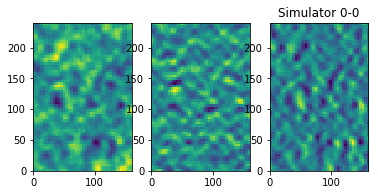

[output:1]

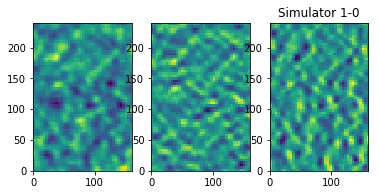

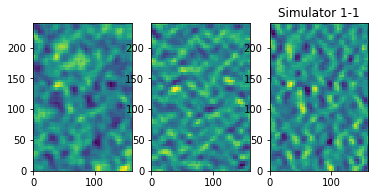

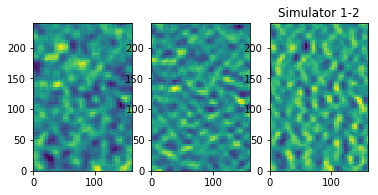

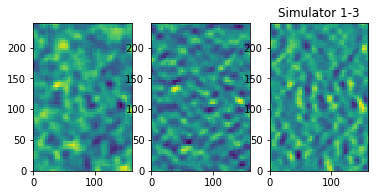

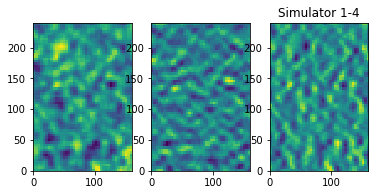

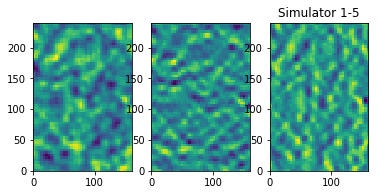

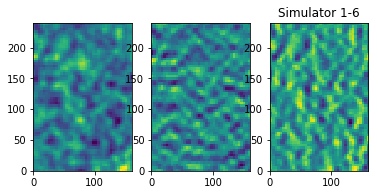

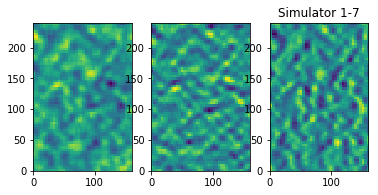

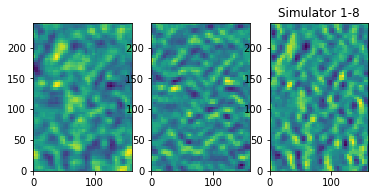

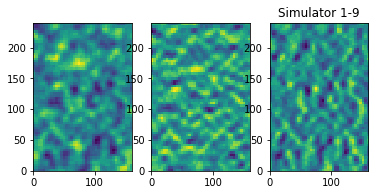

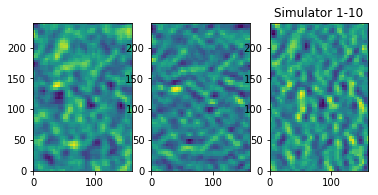

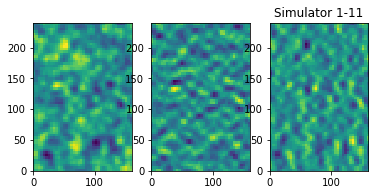

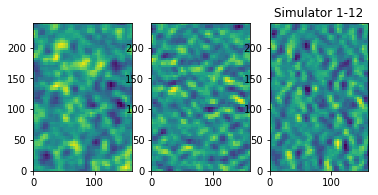

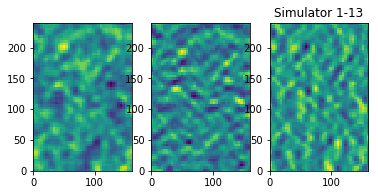

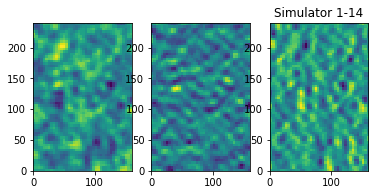

[output:2]

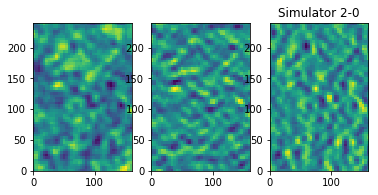

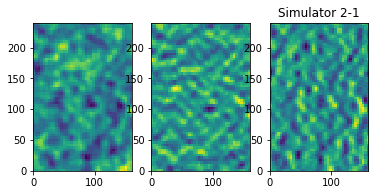

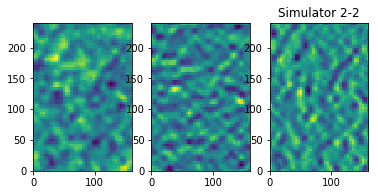

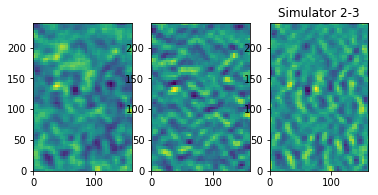

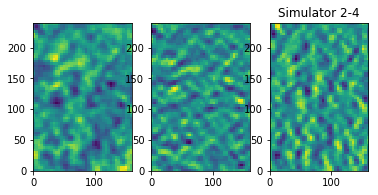

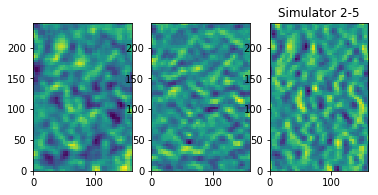

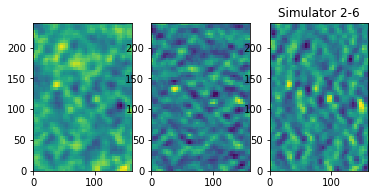

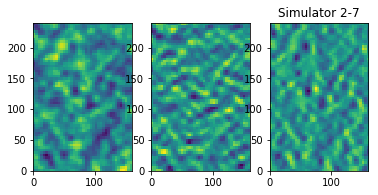

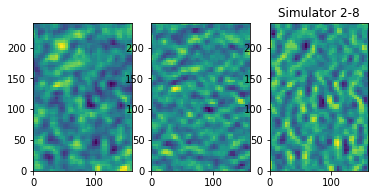

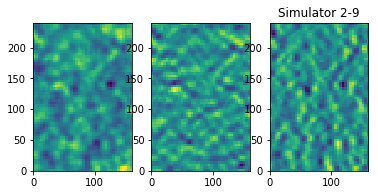

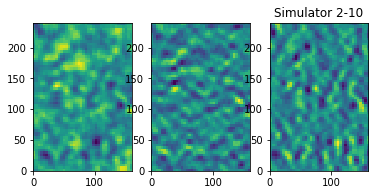

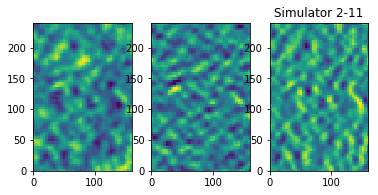

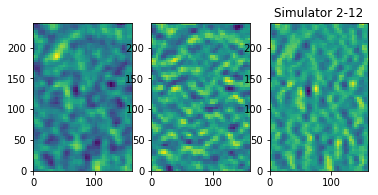

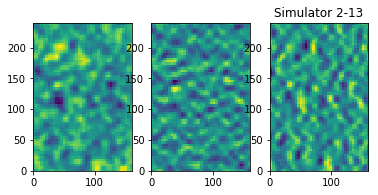

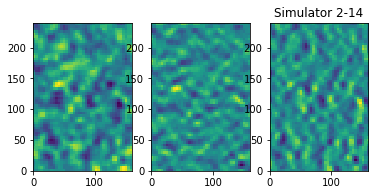

In [10]:
%%px

#Plot initial ensemble


#Plot all particles on all nodes
for i, particle in enumerate(ensemble.ensemble.particles):
    extent = [0, ensemble.sim_args['nx']*ensemble.sim_args['dx'], 0, ensemble.sim_args['ny']*ensemble.sim_args['dy']]
    
    fig = plt.figure()
    eta, hu, hv = particle.download(interior_domain_only=True)
    plt.subplot(1,3,1)
    plt.imshow(eta, extent=extent)
    #plt.plot(drifter_positions[:,0], drifter_positions[:,1], 'ro', fillstyle='none')
    plt.subplot(1,3,2)
    plt.imshow(hu, extent=extent)
    #plt.plot(drifter_positions[:,0], drifter_positions[:,1], 'ro', fillstyle='none')
    plt.subplot(1,3,3)
    plt.imshow(hv, extent=extent)
    #plt.plot(drifter_positions[:,0], drifter_positions[:,1], 'ro', fillstyle='none')
    plt.title("Simulator " + str(MPI.COMM_WORLD.rank) + "-" + str(i))

In [11]:
%%px



#FIXME: WARNING: this performs superfluous work just for plotting
def gatherPlottingInfo(ensemble):
    
    range_x = np.sqrt(ensemble.ensemble.observation_variance)*20
    
    #Gather innovatoins and then remove root / master
    local_innovations = ensemble._localGetInnovations()
    local_innovations_norm = np.linalg.norm(np.linalg.norm(local_innovations, axis=2), axis=1).astype(np.float32)
    global_innovations_norm = None
    if (ensemble.comm.rank == 0):
        global_innovations_norm = np.empty((ensemble.num_nodes+1, ensemble.local_ensemble_size), dtype=np.float32)
    ensemble.comm.Gather(local_innovations_norm, global_innovations_norm, root=0)
    if (ensemble.comm.rank == 0):
        global_innovations_norm = global_innovations_norm[1:].ravel()
        

    #Gather gaussian pdf and then remove root / master
    use_true_gaussian_pdf=False
    if (use_true_gaussian_pdf):
        local_gaussian_pdf = ensemble._localGetGaussianPDF(local_innovations)
        global_gaussian_pdf = None
        if (ensemble.comm.rank == 0):
            global_gaussian_pdf = np.empty((ensemble.num_nodes+1, ensemble.local_ensemble_size))
        ensemble.comm.Gather(local_gaussian_pdf, global_gaussian_pdf, root=0)
        if (ensemble.comm.rank == 0):
            global_gaussian_pdf = global_gaussian_pdf[1:].ravel()
    else:
        #FIXME: This is butt ugly but gives the analytical gaussian distribution
        global_gaussian_pdf = None
        if (ensemble.comm.rank == 0):
            x = np.zeros((100, ensemble.num_drifters, 2))
            x[:,0,0] = np.linspace(0, (range_x), 100)
            global_gaussian_pdf = ensemble._localGetGaussianPDF(x)
    
    
    #Get the normalized weights
    global_normalized_weights = ensemble.getNormalizedWeights()
    
    return {
        'range_x': range_x,
        'gauss_pdf': global_gaussian_pdf,
        'gauss_weights': global_normalized_weights,
        'innovations': global_innovations_norm
    }

# Main loop

In [12]:
%%px

#Perform actual data assimilation

resampling_times = np.linspace(100, 500, 5)*ensemble.sim_args['dt']

if (ensemble.comm.rank == 0):
    print("Will resample at times: ", resampling_times)
    plotting_info = []
    
t = 0
for i, resampling_time in enumerate(resampling_times):
    #Step all nodes in time to next assimilation stage
    assimilation_dt = resampling_time - t
    t = ensemble.modelStep(assimilation_dt)

    
    
    
    # Get info before step for plotting
    # FIXME: Expensive and only for plotting
    ensemble_stats_pre = gatherPlottingInfo(ensemble)
        
        
        
        
    
    #Gather the gaussian weights from all nodes to a global vector on rank 0
    global_normalized_weights = ensemble.getNormalizedWeights()
    
    #Resample the particles
    ensemble.resampleParticles(global_normalized_weights)
    
    
    
    
    #Get info for plotting
    #FIXME: Expensive and only for plotting
    ensemble_stats_post = gatherPlottingInfo(ensemble)
    if ensemble.comm.rank == 0:
        plotting_info.append([resampling_time, ensemble_stats_pre, ensemble_stats_post])
        
        
    print(".", end="", flush=True)

[stdout:0] 
Will resample at times:  [ 5. 10. 15. 20. 25.]
.....
[stdout:1] .....
[stdout:2] .....


[stderr:0] 
/home/martinls/.local/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


[output:0]

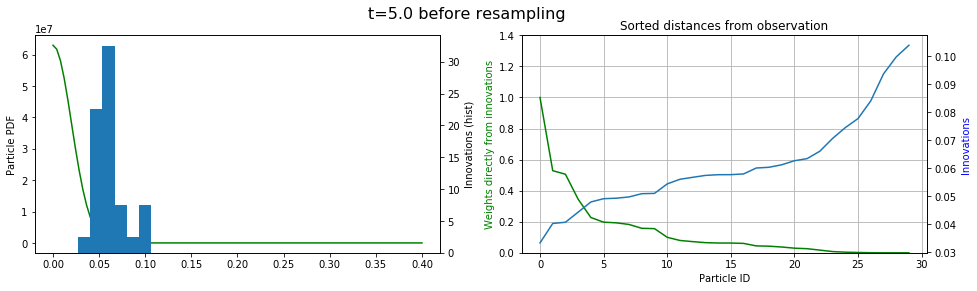

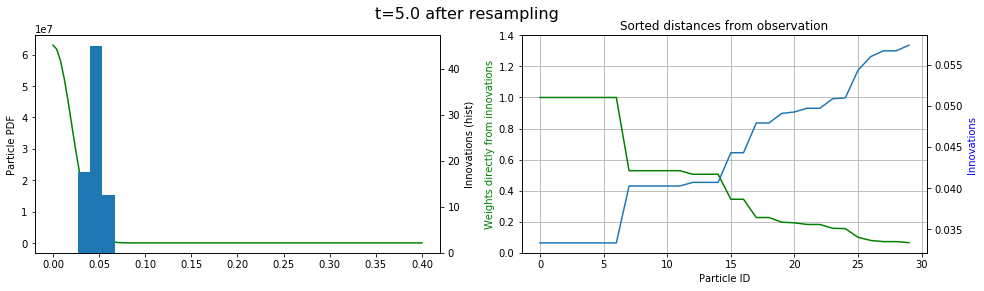

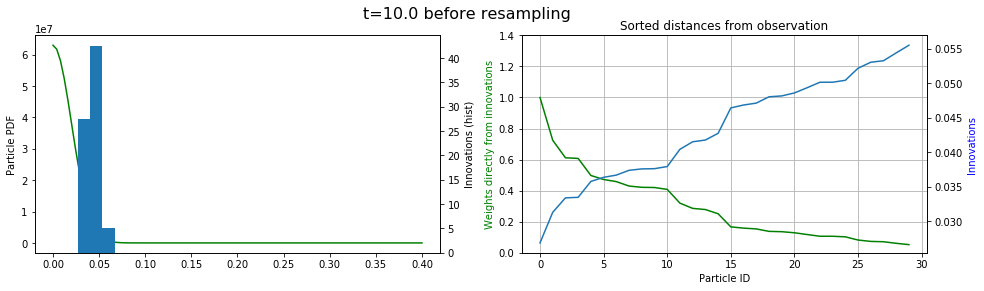

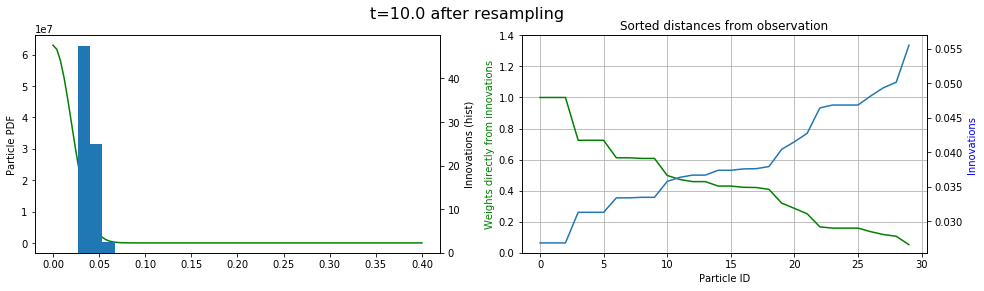

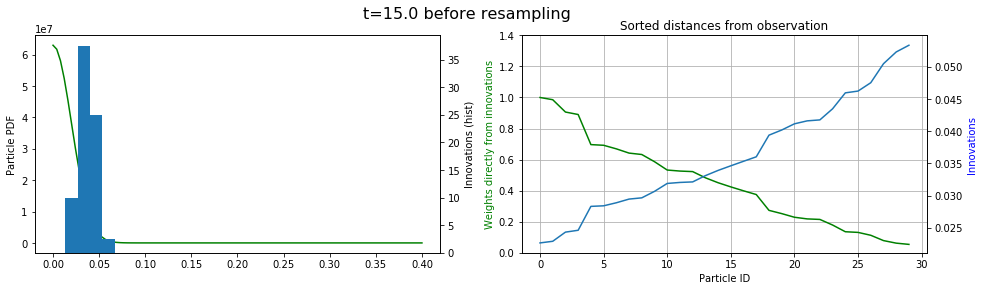

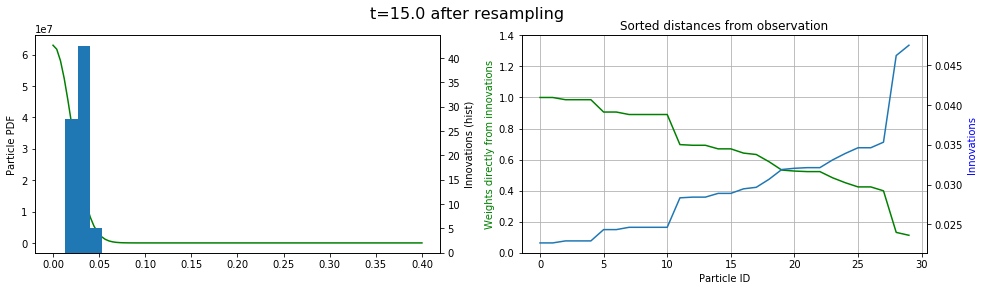

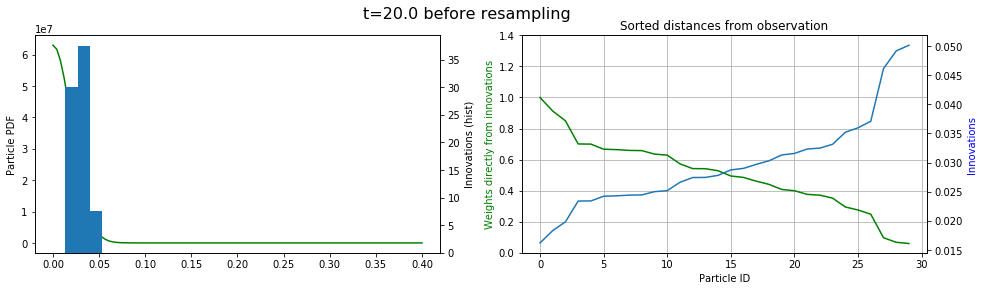

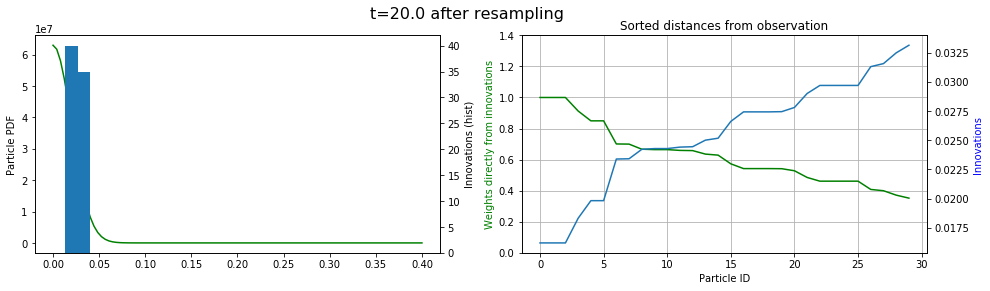

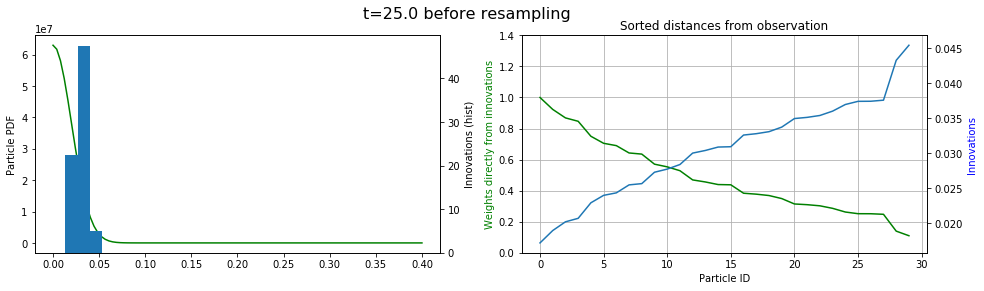

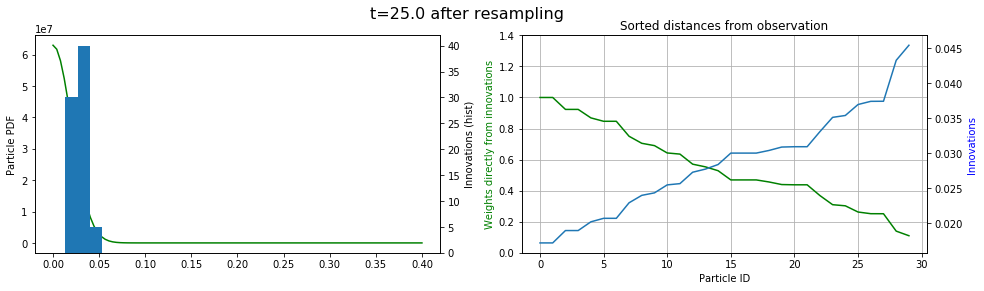

In [13]:
%%px 

def plotDistanceInfo(ensemble_info, title=None):
    # Only rank 0 creates a figure:
    fig = None
    fig = plt.figure(figsize=(16, 4))


    # PLOT DISCTRIBUTION OF PARTICLE DISTANCES AND THEORETIC OBSERVATION PDF
    ax0 = plt.subplot(1,2,1)

    # With observation 
    x = np.linspace(0, ensemble_info['range_x'], num=len(ensemble_info['gauss_pdf']))
    ax0.plot(x, ensemble_info['gauss_pdf'], 'g', label="pdf directly from innovations")
    ax0.set_ylabel('Particle PDF')
    #plt.legend()
    #plt.title("Distribution of particle innovations")

    #hisograms:
    ax1 = ax0.twinx()
    ax1.hist(ensemble_info['innovations'], bins=30, \
             range=(0, ensemble_info['range_x']),\
             normed=True, label="particle innovations (norm)")
    ax1.set_ylabel('Innovations (hist)')

    # PLOT SORTED DISTANCES FROM OBSERVATION
    ax0 = plt.subplot(1,2,2)
    indices_sorted_by_observation = ensemble_info['innovations'].argsort()
    ax0.plot(ensemble_info['gauss_weights'][indices_sorted_by_observation]/np.max(ensemble_info['gauss_weights']),\
             'g', label="Weight directly from innovations")
    ax0.set_ylabel('Weights directly from innovations', color='g')
    ax0.grid()
    ax0.set_ylim(0,1.4)
    #plt.legend(loc=7)
    ax0.set_xlabel('Particle ID')

    ax1 = ax0.twinx()
    ax1.plot(ensemble_info['innovations'][indices_sorted_by_observation], label="innovations")
    ax1.set_ylabel('Innovations', color='b')

    plt.title("Sorted distances from observation")

    if title is not None:
        plt.suptitle(title, fontsize=16)
    #plt.tight_layout()

    return fig

# Plot results
if ensemble.comm.rank == 0:
    for time, pre, post in plotting_info:
        infoFig = plotDistanceInfo(pre, title="t=" + str(time) + " before resampling")
        infoFig = plotDistanceInfo(post, title="t=" + str(time) + " after resampling")


[output:0]

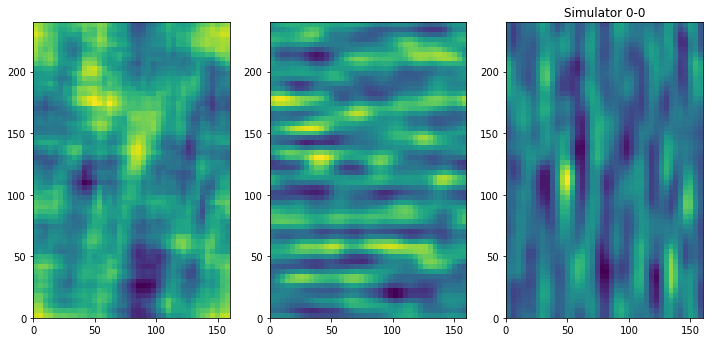

[output:1]

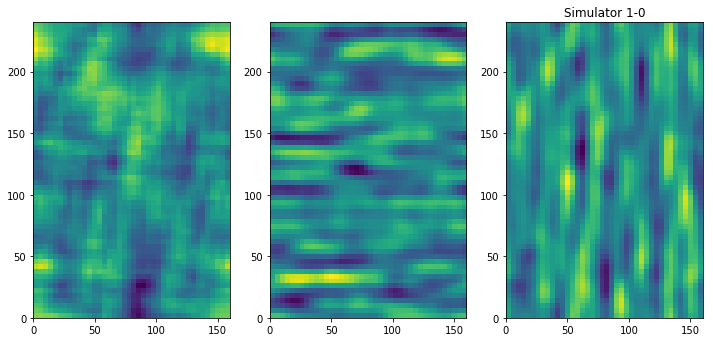

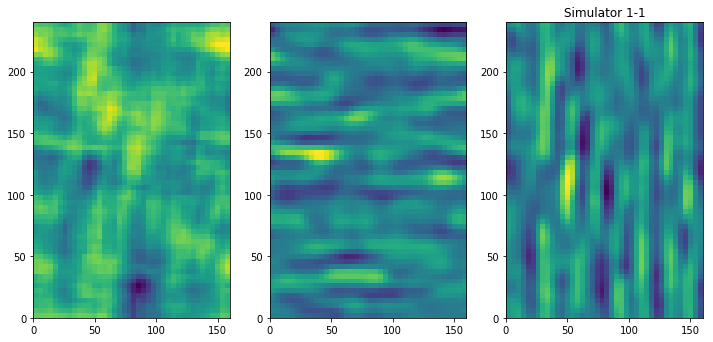

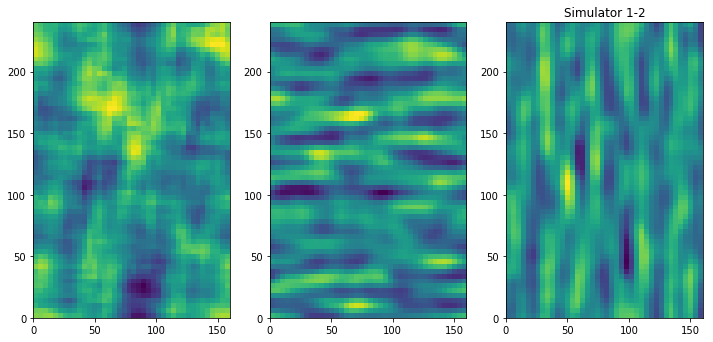

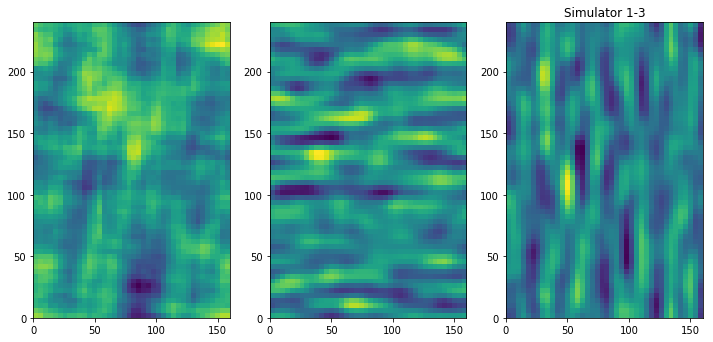

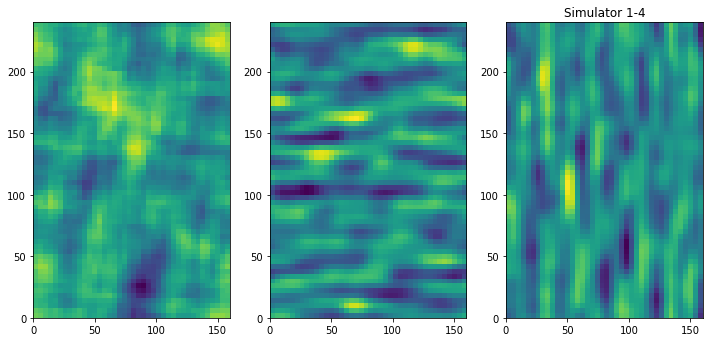

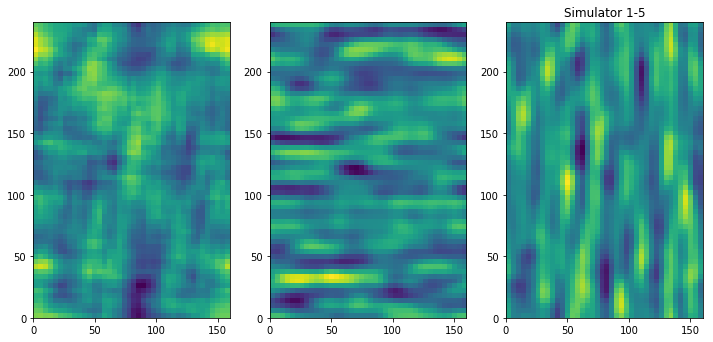

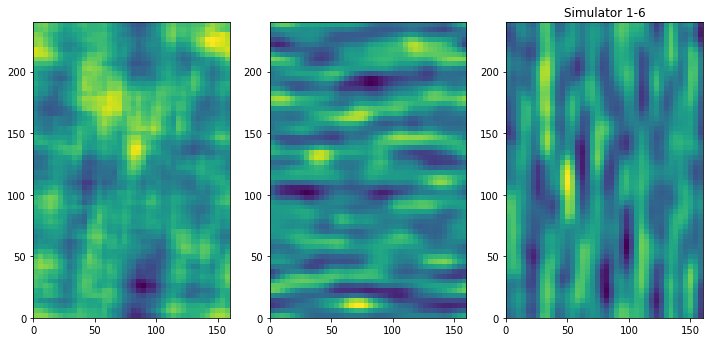

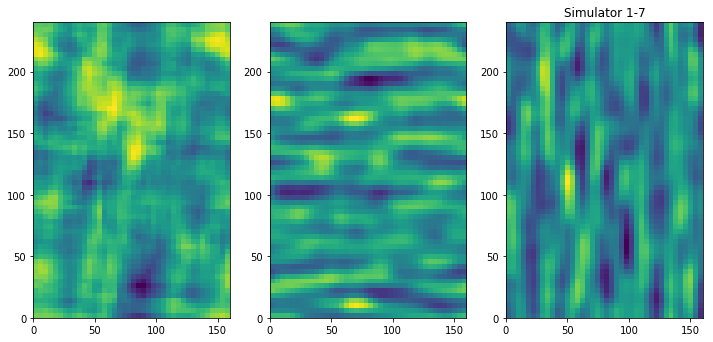

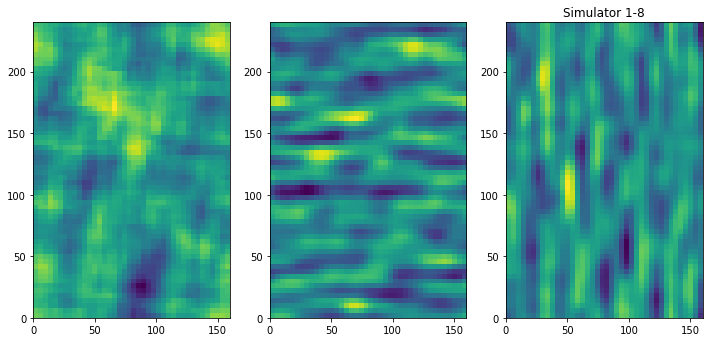

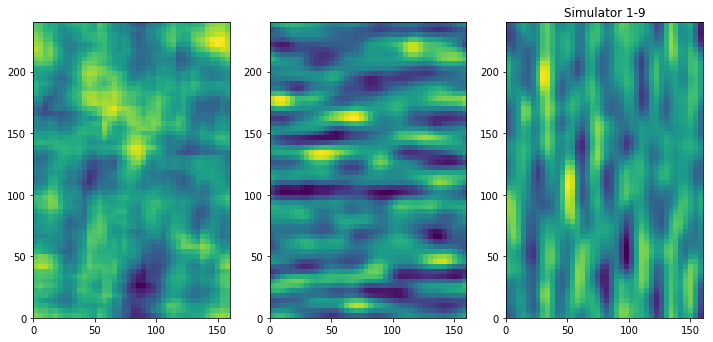

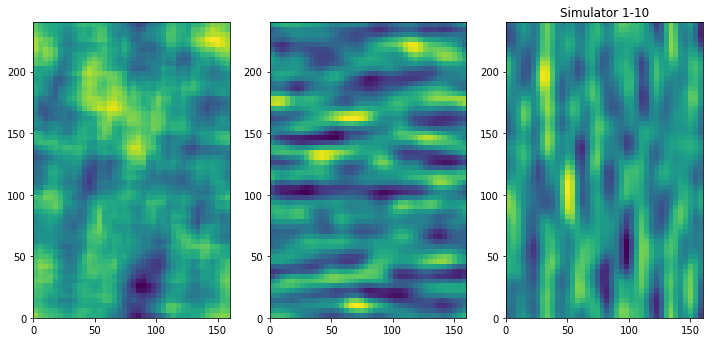

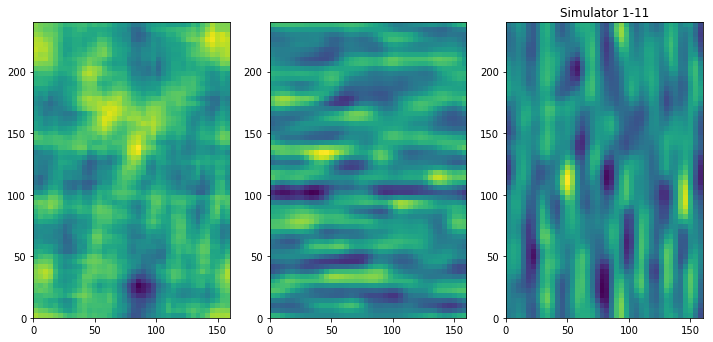

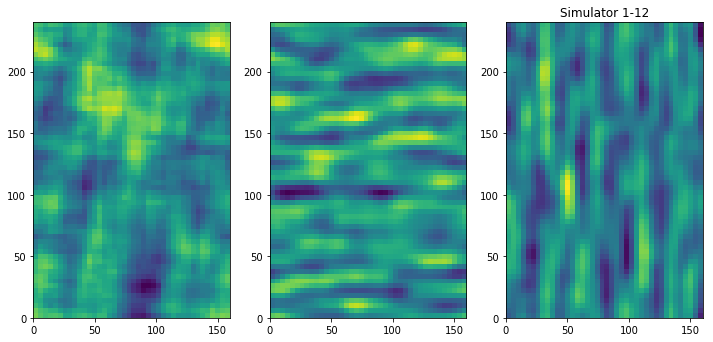

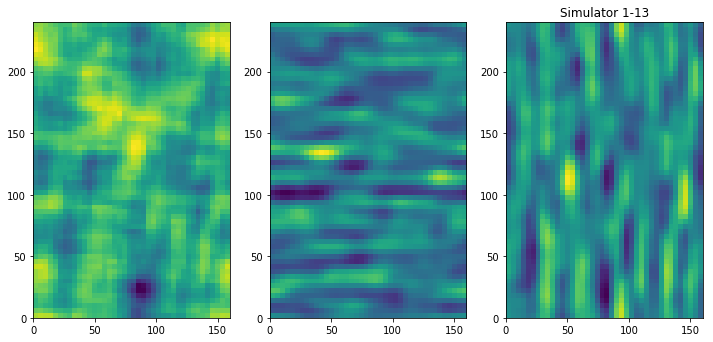

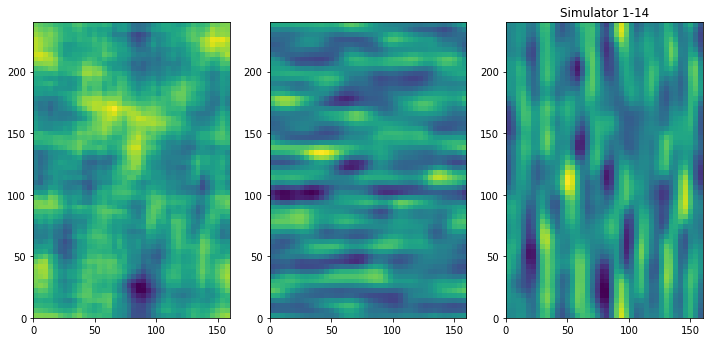

[output:2]

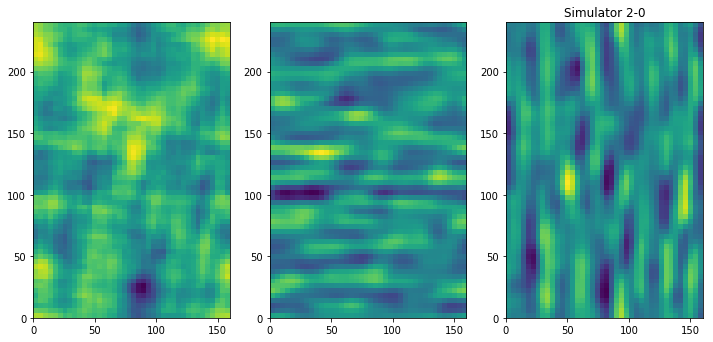

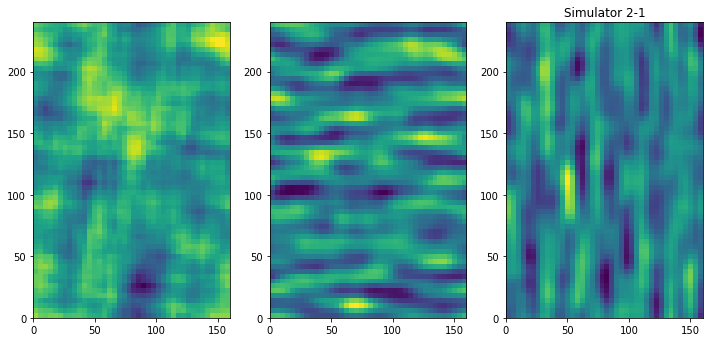

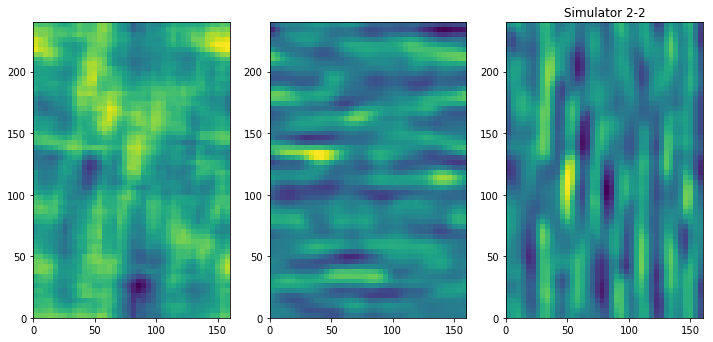

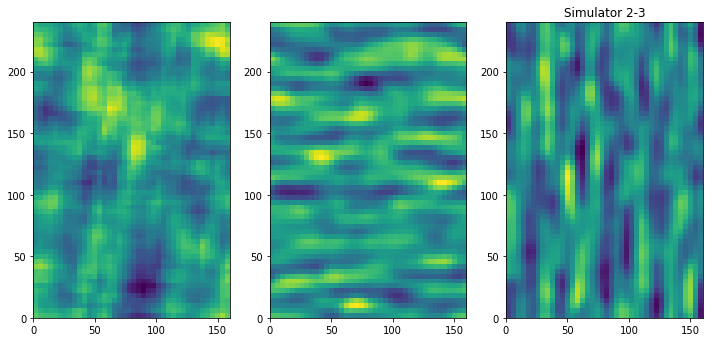

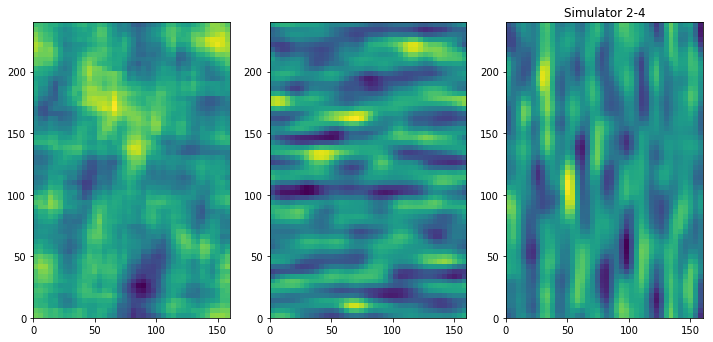

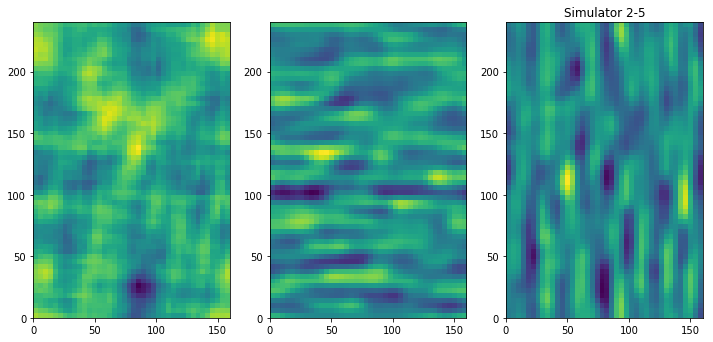

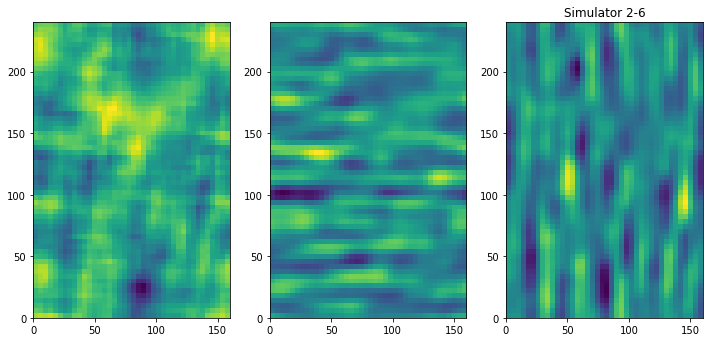

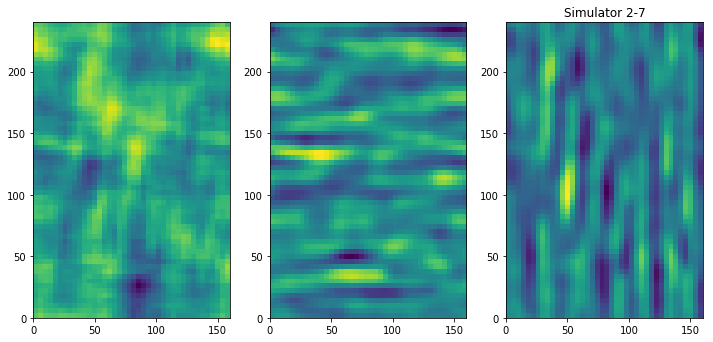

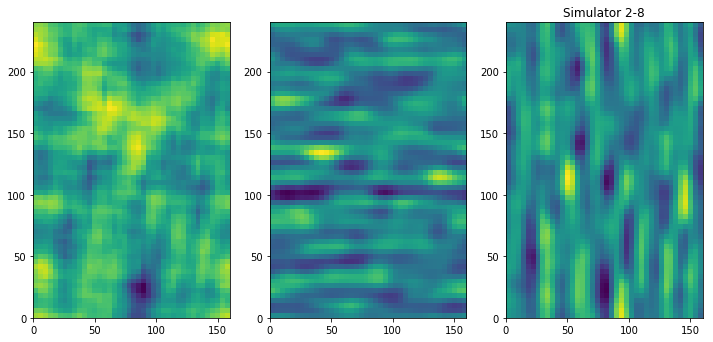

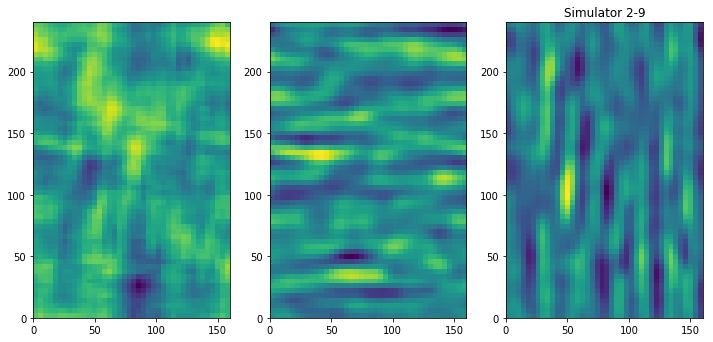

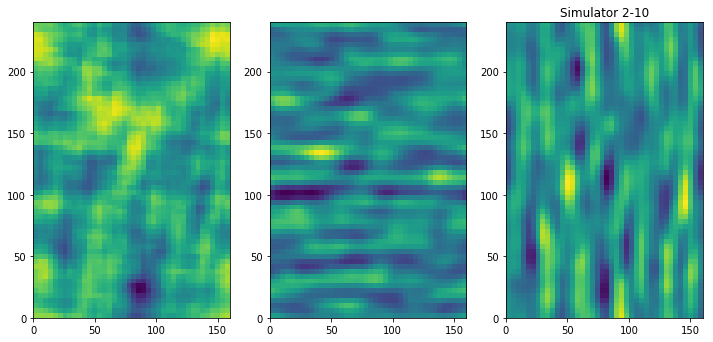

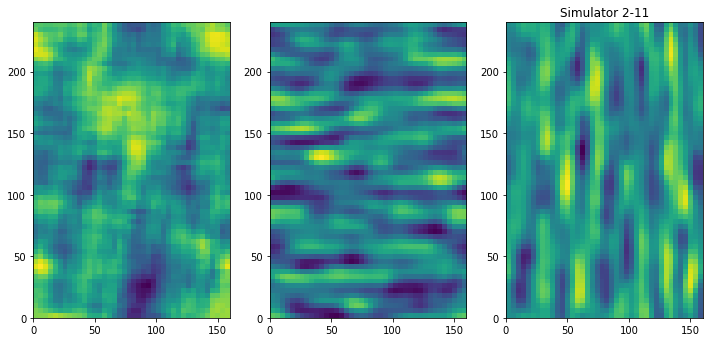

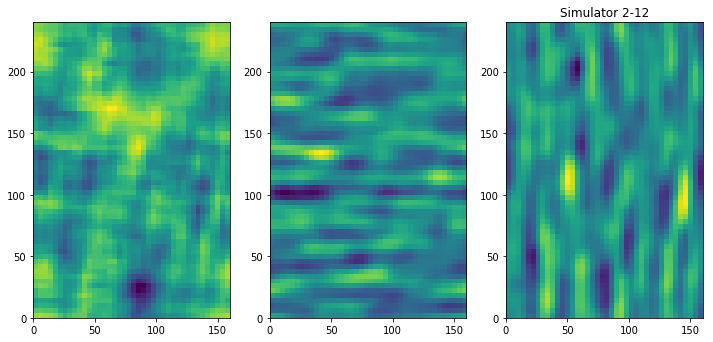

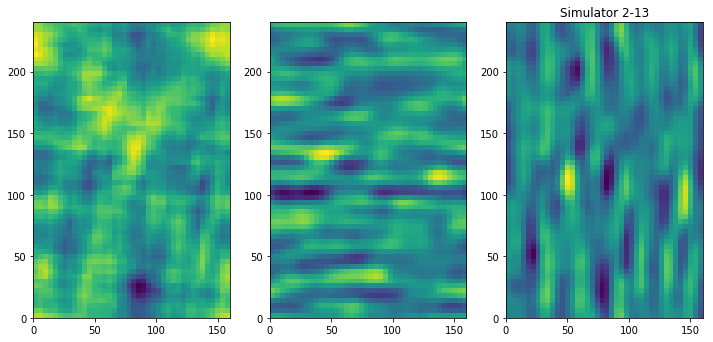

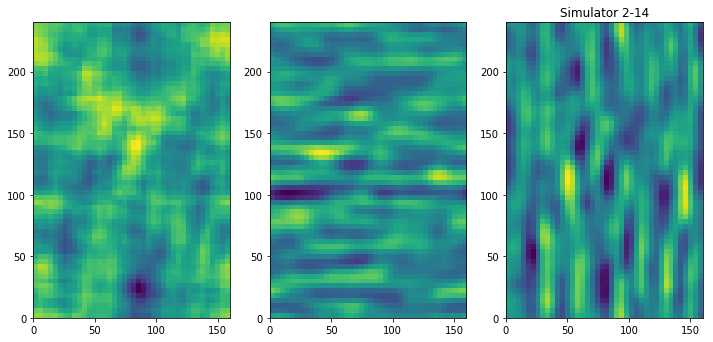

In [14]:
%%px


#Plot all particles on all nodes
for i, particle in enumerate(ensemble.ensemble.particles):
    extent = [0, ensemble.sim_args['nx']*ensemble.sim_args['dx'], 0, ensemble.sim_args['ny']*ensemble.sim_args['dy']]
    
    fig = plt.figure(figsize=(12, 8))
    eta, hu, hv = particle.download(interior_domain_only=True)
    plt.subplot(1,3,1)
    plt.imshow(eta, extent=extent)
    #plt.plot(drifter_positions[:,0], drifter_positions[:,1], 'ro', fillstyle='none')
    plt.subplot(1,3,2)
    plt.imshow(hu, extent=extent)
    #plt.plot(drifter_positions[:,0], drifter_positions[:,1], 'ro', fillstyle='none')
    plt.subplot(1,3,3)
    plt.imshow(hv, extent=extent)
    #plt.plot(drifter_positions[:,0], drifter_positions[:,1], 'ro', fillstyle='none')
    plt.title("Simulator " + str(MPI.COMM_WORLD.rank) + "-" + str(i))